# Import Libraries

In [14]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [15]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [16]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [17]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [18]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


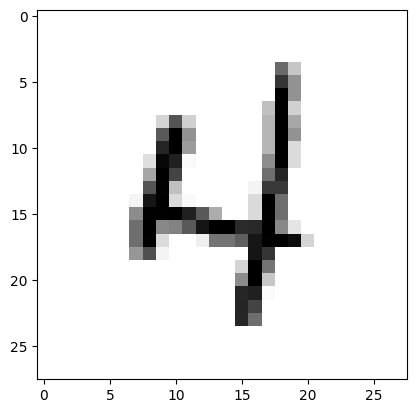

In [19]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

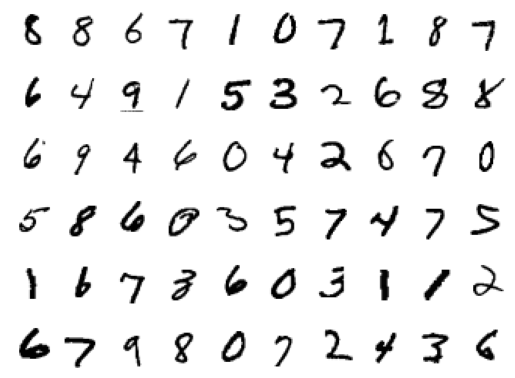

In [20]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [21]:
# importing the model from the model.py
from model import Net

model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
       BatchNorm2d-2            [-1, 4, 26, 26]               8
              ReLU-3            [-1, 4, 26, 26]               0
            Conv2d-4            [-1, 4, 24, 24]             144
       BatchNorm2d-5            [-1, 4, 24, 24]               8
              ReLU-6            [-1, 4, 24, 24]               0
            Conv2d-7            [-1, 4, 22, 22]             144
       BatchNorm2d-8            [-1, 4, 22, 22]               8
              ReLU-9            [-1, 4, 22, 22]               0
          Dropout-10            [-1, 4, 22, 22]               0
        MaxPool2d-11            [-1, 4, 11, 11]               0
           Conv2d-12            [-1, 8, 11, 11]              32
      BatchNorm2d-13            [-1, 8, 11, 11]              16
             ReLU-14            [-1, 8,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [22]:
# Function fopr Training the model of the train dataset.
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Calculate loss
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        #pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

# Testing the trained model on test dataset to the check loss and model accuracy
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Let's Train and test our model

In [23]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Train: Loss=0.0428 Batch_id=468 Accuracy=88.75: 100%|██████████| 469/469 [00:19<00:00, 23.85it/s]



Test set: Average loss: 0.1077, Accuracy: 9698/10000 (96.98%)

EPOCH: 1


Train: Loss=0.0730 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]



Test set: Average loss: 0.0540, Accuracy: 9850/10000 (98.50%)

EPOCH: 2


Train: Loss=0.0579 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]



Test set: Average loss: 0.0444, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


Train: Loss=0.0605 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:18<00:00, 25.22it/s]



Test set: Average loss: 0.0383, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Train: Loss=0.0782 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:19<00:00, 24.61it/s]



Test set: Average loss: 0.0437, Accuracy: 9861/10000 (98.61%)

EPOCH: 5


Train: Loss=0.0117 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:18<00:00, 25.46it/s]



Test set: Average loss: 0.0345, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Train: Loss=0.0151 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:18<00:00, 24.93it/s]



Test set: Average loss: 0.0289, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Train: Loss=0.0777 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]



Test set: Average loss: 0.0316, Accuracy: 9893/10000 (98.93%)

EPOCH: 8


Train: Loss=0.0113 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]



Test set: Average loss: 0.0353, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Train: Loss=0.0549 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]



Test set: Average loss: 0.0265, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Train: Loss=0.0146 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:19<00:00, 24.28it/s]



Test set: Average loss: 0.0293, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Train: Loss=0.0285 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:18<00:00, 25.20it/s]



Test set: Average loss: 0.0331, Accuracy: 9894/10000 (98.94%)

EPOCH: 12


Train: Loss=0.0040 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:19<00:00, 23.72it/s]



Test set: Average loss: 0.0291, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Train: Loss=0.0311 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:18<00:00, 25.50it/s]



Test set: Average loss: 0.0262, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Train: Loss=0.0193 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]



Test set: Average loss: 0.0266, Accuracy: 9908/10000 (99.08%)



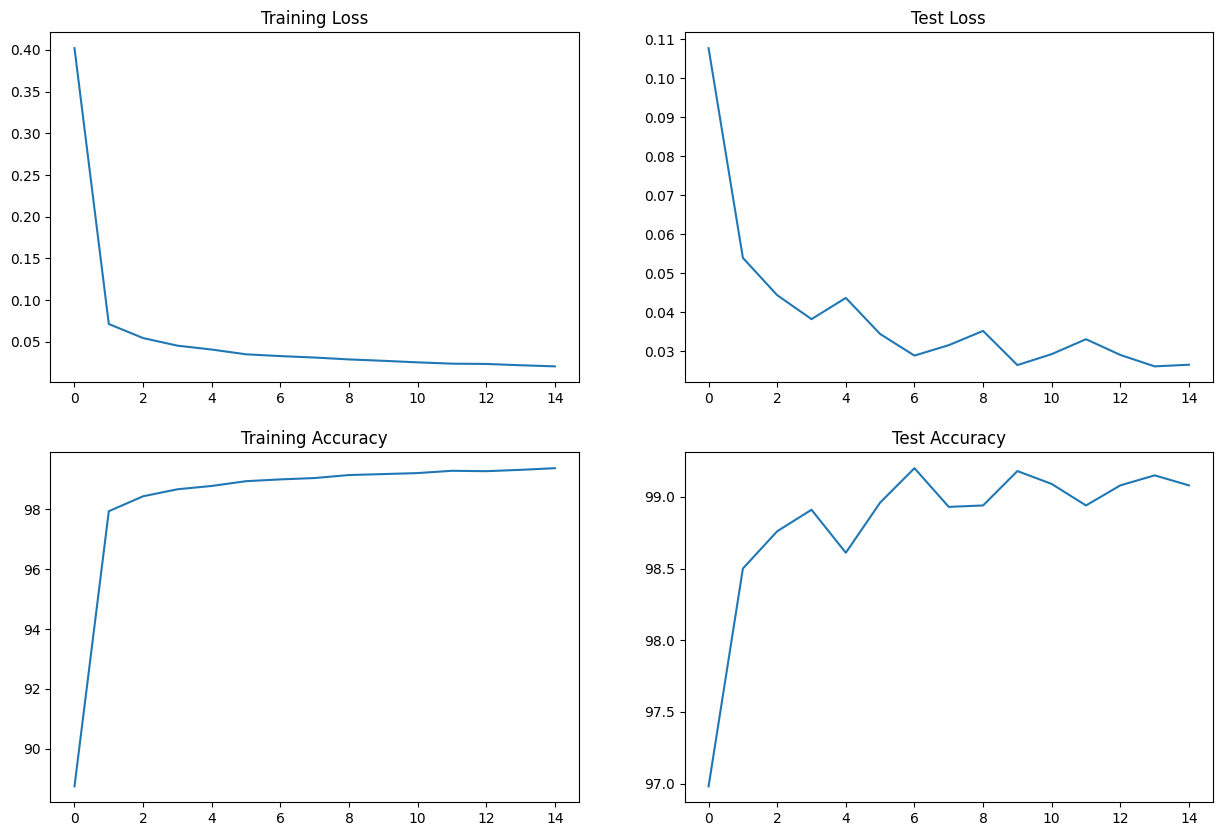

In [24]:
# Display the loss and accuracy in tranining and Test Data.
from utils import display_plot

display_plot(train_losses,train_acc,test_losses,test_acc)

## Model 1

Results:

*   Parameters: 7,596
*   Best Train Accuracy: 99.36%
*   Best Test Accuracy: 99.20%


*   Analysis:
Model is slightly overfitting. As the number of epoch increases the model training is moving towards overfitting. Though model parameter count is pretty small.




